In [3]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import easyocr
reader = easyocr.Reader(['en'])

%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans

import os

In [13]:
path_model = r'E:\IAMDAT\Workplace\DOANCUOIKY\FinalVersion\models\best_lp_4.pt'
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model = torch.hub.load('../yolov5', 'custom', path=path_model, source='local').to(device)  # local repo
model.eval()


model_detect_number = torch.hub.load('../yolov5', 'custom', path=r'E:\IAMDAT\Workplace\DOANCUOIKY\FinalVersion\models\detect_number_3.pt', source='local').to(device)  # local repo
model_detect_number.eval()

YOLOv5  v6.1-132-g014acde torch 1.11.0+cu113 CUDA:0 (Quadro M500M, 2048MiB)

Fusing layers... 
Model summary: 213 layers, 1760518 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  v6.1-132-g014acde torch 1.11.0+cu113 CUDA:0 (Quadro M500M, 2048MiB)

Fusing layers... 
Model summary: 213 layers, 1807873 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): Model(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
           

In [14]:
img = cv2.imread(r'E:\IAMDAT\Workplace\DOANCUOIKY\estimation_speed_vehice\images\sub_images\5.jpg')
# 
a = time.time()
bbox = model(img).pandas().xyxy[0].to_numpy()
bbox = bbox[bbox[:,5]==max(bbox[:,5])][0]
print(time.time() - a)
bbox

0.03801155090332031


array([41.8837890625, 356.6057434082031, 109.54825592041016, 407.1102294921875, 0.9237081408500671, 0, 'plate'], dtype=object)

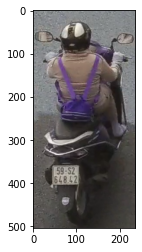

In [15]:
plt.imshow(img)

59-52-(648,42


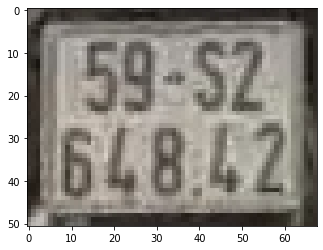

In [16]:
def get_license_plate(image):

    bbox = model(img).pandas().xyxy[0].to_numpy()
    bbox = bbox[bbox[:,5]==max(bbox[:,5])][0]
    xmin, ymin, xmax, ymax = bbox[0:4]
    
    img_license_plate = image[int(ymin):int(ymax), int(xmin):int(xmax)]	

    predict = reader.readtext(img_license_plate)
    results = predict[0][-2]+"-"+predict[1][-2]
    print(results)
    
    return img_license_plate

new =get_license_plate(img)
plt.imshow(new,'gray')

In [17]:
# def GDS(arr):
#     gds = []
#     mean = np.mean(arr)
#     std = np.std(arr)
#     th=3
#     p_max, p_min = mean+std, mean-std
#     for i in range(th, len(arr)-th):
#         if ((arr[i]<np.mean(arr[i-th:i]) and arr[i]>np.mean(arr[i:i+th])) or (arr[i]>np.mean(arr[i-th:i]) and arr[i]<np.mean(arr[i:i+th]))) and arr[i]<= p_max and arr[i]>=p_min:
#             gds.append(i)
#     return gds

def applySummFunctin(img, axis = 1):
    res = np.sum(img, axis = axis)    #  summ elements in columns
    return res

def splitLine(img):
    if (img.shape[0]/img.shape[1])<(1/3):
        return None

    s1 = applySummFunctin(img, axis =1)
    lst_max = np.where(s1== max(s1))[0]
    deadline = lst_max[int(len(lst_max)/2)]
    if deadline<(1/3)*len(s1) - deadline or deadline>(1/3)*len(s1) - deadline :
        deadline = int(len(s1)/2)

    
    return deadline
    # return [line1, line2],[line1_binary, line2_binary]

def sort(bboxes, deadline):
    if deadline == None:
        return np.argsort(bboxes[:,-2])
    else:
        l1 = bboxes[bboxes[:,-1]<deadline]
        l2 = bboxes[bboxes[:,-1]>deadline]
        return np.concatenate((l1[np.argsort(l1[:,-2])], l2[np.argsort(l2[:,-2])]))

def get_license_plate(image):

    bbox = model(img).pandas().xyxy[0].to_numpy()
    bbox = bbox[bbox[:,5]==max(bbox[:,5])][0]
    xmin, ymin, xmax, ymax = bbox[0:4]
    
    img_license_plate = image[int(ymin):int(ymax), int(xmin):int(xmax)]	
    
    return img_license_plate

def recognize_plate(img_plate):
    img_plate =cv2.cvtColor(img_plate, cv2.COLOR_BGR2GRAY)#COLOR_BGR2GRAY
    bboxes = model_detect_number(img_plate).pandas().xyxy[0].to_numpy()
    bboxes = np.append(bboxes, (bboxes[:,0]+(bboxes[:,2]-bboxes[:,0])/2).reshape(-1,1), axis = 1)
    bboxes =  np.append(bboxes, (bboxes[:,1]+(bboxes[:,3]-bboxes[:,1])/2).reshape(-1,1), axis = 1)
    deadline = splitLine(img_plate)

    return ''.join(sort(bboxes, deadline)[:,6])

def full_detect(image):
    img_plate = get_license_plate(image)
    return recognize_plate(img_plate)

    # bbox.sort()

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# init license plate model
licensePlateModel = torch.hub.load('../yolov5', 'custom', path='../models/best_lp_4.pt', source='local').to(device)  # local repo
licensePlateModel.eval()

# init license plate model
model_detetect_number = torch.hub.load('../yolov5', 'custom', path='../models/detect_number_3.pt', source='local').to(device)  # local repo
model_detetect_number.eval()


def splitLine(img):
    if (img.shape[0]/img.shape[1])<(1/3):
        return None

    s1 = applySummFunctin(img, axis =1)
    lst_max = np.where(s1== max(s1))[0]
    deadline = lst_max[int(len(lst_max)/2)]
    if deadline<(1/3)*len(s1) - deadline or deadline>(1/3)*len(s1) - deadline :
        deadline = int(len(s1)/2)    
    return deadline


def sort(bboxes, deadline):
    if deadline == None:
        return bboxes[np.argsort(bboxes[:,-2])]
    else:
        l1 = bboxes[bboxes[:,-1]<deadline]
        l2 = bboxes[bboxes[:,-1]>deadline]
        return np.concatenate((l1[np.argsort(l1[:,-2])], l2[np.argsort(l2[:,-2])]))


def get_license_plate(image):

        bboxes = licensePlateModel(image).pandas().xyxy[0].to_numpy()
        if len(bboxes)==0:
            return None, 'Cant detect vehicle !'
        bboxes = bboxes[bboxes[:,5]==max(bboxes[:,5])][0]
        xmin, ymin, xmax, ymax = bboxes[0:4]
        img_license_plate = image[int(ymin):int(ymax), int(xmin):int(xmax)]
        
        return img_license_plate, None

def recognize_plate(img_plate):
    img_plate =cv2.cvtColor(img_plate, cv2.COLOR_BGR2GRAY)#COLOR_BGR2GRAY
    bboxes = model_detetect_number(img_plate).pandas().xyxy[0].to_numpy()
    bboxes = np.append(bboxes, (bboxes[:,0]+(bboxes[:,2]-bboxes[:,0])/2).reshape(-1,1), axis = 1)
    bboxes =  np.append(bboxes, (bboxes[:,1]+(bboxes[:,3]-bboxes[:,1])/2).reshape(-1,1), axis = 1)
    deadline = splitLine(img_plate)
    return ''.join(sort(bboxes, deadline)[:,6])

def Full_Detect(image):
    img_plate,err= get_license_plate(image)
    if err != None:
        return 'can\'t detection'   
    return recognize_plate(img_plate)

YOLOv5  v6.1-132-g014acde torch 1.11.0+cu113 CUDA:0 (Quadro M500M, 2048MiB)

Fusing layers... 
Model summary: 213 layers, 1760518 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  v6.1-132-g014acde torch 1.11.0+cu113 CUDA:0 (Quadro M500M, 2048MiB)

Fusing layers... 
Model summary: 213 layers, 1807873 parameters, 0 gradients
Adding AutoShape... 


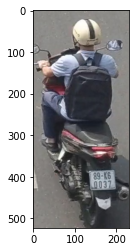

In [58]:
img = cv2.imread(r'E:\IAMDAT\Workplace\DOANCUOIKY\DesktopApp\core\images\vehicle\1649952036.5954332.jpg')
img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

D:\ProgramData\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x, subok=True, copy=copy)


TypeError: Image data of dtype object cannot be converted to float

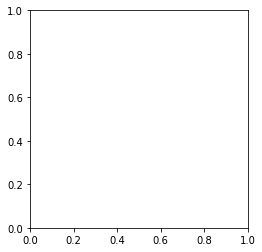

In [62]:

img = get_license_plate(img)
plt.imshow(img)

TypeError: Image data of dtype <U9 cannot be converted to float

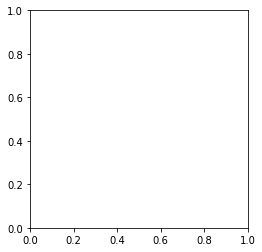

In [19]:
plt.imshow(recognize_plate(new),'gray')

In [14]:
new.shape

(74, 117, 3)

In [27]:
img = cv2.imread(r'E:\IAMDAT\Workplace\DOANCUOIKY\DesktopApp\core\images\vehicle\1649952036.5954332.jpg')
# img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
a = time.time()
bbox = model(img).pandas().xyxy[0].to_numpy()
bbox = bbox[bbox[:,5]==max(bbox[:,5])][0]
print(time.time() - a)
bbox

0.04300379753112793


array([130.0982666015625, 381.4159240722656, 201.52586364746094, 436.2419128417969, 0.9087315201759338, 0, 'plate'], dtype=object)

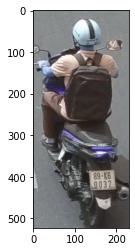

In [28]:
plt.imshow(img)
# reader.readtext(img)

[130.0982666015625 381.4159240722656 201.52586364746094 436.2419128417969 0.9087315201759338 0 'plate']
89 K6-djz


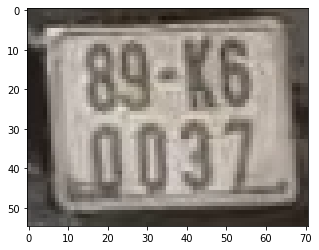

In [29]:
def get_license_plate(image):

    bbox = model(img).pandas().xyxy[0].to_numpy()
    bbox = bbox[bbox[:,5]==max(bbox[:,5])][0]
    print(bbox)
    xmin, ymin, xmax, ymax = bbox[0:4]
    
    img_license_plate = image[int(ymin):int(ymax), int(xmin):int(xmax)]	

    predict = reader.readtext(img_license_plate)
    results = predict[0][-2]+"-"+predict[1][-2]
    print(results)
    
    return img_license_plate

new =get_license_plate(img)
plt.imshow(new,'gray')

In [30]:
def region_growing(img, x, y, delta=15):
    """
        x: relative coord (0-1)
        y: relative coord (0-1)
    """
    def is_valid_px(x, y, img):
        if x>=0 and x<img.shape[1] and y>=0 and y<img.shape[0]:
            return True
        return False
    mask = np.zeros(img.shape[:2])
    y_abs = int(y * img.shape[0])
    x_abs = int(x * img.shape[1])
    
    loop_points = []
    loop_points.append((x_abs, y_abs))
    px_intensity = img[y_abs, x_abs, :]
    blue = px_intensity[0]
    green = px_intensity[1]
    red = px_intensity[2]
    
    while len(loop_points) != 0:
        (cx, cy) = loop_points.pop()
        current_intensity = img[cy, cx, :]
        b = int(current_intensity[0])
        g = int(current_intensity[1])
        r = int(current_intensity[2])
        
        if abs(r-red)<delta and abs(g-green)<delta and abs(b-blue)<delta:
            mask[cy, cx] = 255
            neighbors = [
                (cx-1, cy),
                (cx+1, cy),
                (cx-1, cy-1),
                (cx, cy-1),
                (cx+1, cy-1),
                (cx-1, cy+1),
                (cx, cy+1),
                (cx+1, cy+1)
            ]
            for (nx, ny) in neighbors:
                if is_valid_px(nx, ny, img) and mask[ny, nx] == 0:
                    loop_points.append((nx, ny))
        else:
            pass
    return mask

[([[20, 44], [66, 44], [66, 74], [20, 74]], 'Lpi', 0.29175710453861486), ([[41, 11], [112, 11], [112, 77], [41, 77]], '972', 0.959688978798484)]


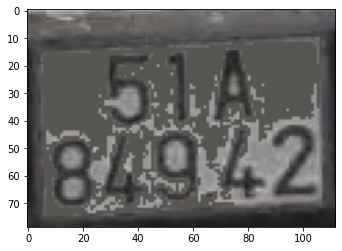

In [126]:
img = new.copy()
# img = img.resize((50,50))
# KERNEL_WIDTH = KERNEL_HEIGHT = 5
# SIGMA_X = SIGMA_Y = 2
# img[:,:,0] = cv2.GaussianBlur(img[:,:,0], ksize=(KERNEL_WIDTH, KERNEL_HEIGHT), sigmaX=SIGMA_X, sigmaY=SIGMA_Y)
# img[:,:,1] = cv2.GaussianBlur(img[:,:,1], ksize=(KERNEL_WIDTH, KERNEL_HEIGHT), sigmaX=SIGMA_X, sigmaY=SIGMA_Y)
# img[:,:,2] = cv2.GaussianBlur(img[:,:,2], ksize=(KERNEL_WIDTH, KERNEL_HEIGHT), sigmaX=SIGMA_X, sigmaY=SIGMA_Y)

y = 15/50
x = 5/60
delta = 20
mask = region_growing(img=new, x=x, y=y, delta=delta)
cv2.imwrite('out_mask.jpg', mask)

img_color = img #cv2.imread("hi.jpg", cv2.IMREAD_COLOR)
img_color[mask>0,:] = img_color[int(x*img.shape[1]), int(y*img.shape[0]),:]  #(255, 255, 255)
    
# cv2.circle(img_color, (int(x*img.shape[1]), int(y*img.shape[0])), radius=5, color=(0, 0, 255), thickness=2)
plt.imshow(img_color,'gray')
print(reader.readtext(img_color))

In [125]:
img_color[int(x*img.shape[1]), int(y*img.shape[0]),:]

array([87, 86, 82], dtype=uint8)

In [85]:
def image_preprocessing(img):
  return np.float32(img.reshape((-1,3)))

In [41]:
kmeans = KMeans(n_clusters=2).fit(image_preprocessing(new))
label  = kmeans.predict(image_preprocessing(new))
u,c = np.unique(label,return_counts=True)
vec =  np.zeros_like(image_preprocessing(new))
for k in range(2):
    if c[k]>c[1-k]:
      vec[label==k] = 0.0
    else:
      vec[label==k] = 1.0
    

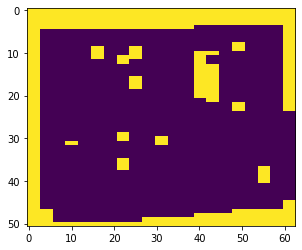

In [42]:
plt.imshow(vec.reshape(new.shape))

In [47]:

def reduce_colors(img, n):
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = n
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    return res2 

In [50]:
def clean_image(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    resized_img = cv2.resize(gray_img
        , None
        , fx=5.0
        , fy=5.0
        , interpolation=cv2.INTER_CUBIC)

    resized_img = cv2.GaussianBlur(resized_img,(5,5),0)
    cv2.imwrite('licence_plate_large.png', resized_img)

    equalized_img = cv2.equalizeHist(resized_img)
    cv2.imwrite('licence_plate_equ.png', equalized_img)


    reduced = cv2.cvtColor(reduce_colors(cv2.cvtColor(equalized_img, cv2.COLOR_GRAY2BGR), 8), cv2.COLOR_BGR2GRAY)
    cv2.imwrite('licence_plate_red.png', reduced)


    ret, mask = cv2.threshold(reduced, 64, 255, cv2.THRESH_BINARY)
    cv2.imwrite('licence_plate_mask.png', mask) 

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask = cv2.erode(mask, kernel, iterations = 1)
    cv2.imwrite('licence_plate_mask2.png', mask)

    return mask

In [13]:
1/0.05

20.0